In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import random
import time
import tqdm
import copy
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn, optim
from torchvision import transforms
from google.colab import drive
from torch.utils.data import TensorDataset, DataLoader

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
dataroot = 'gdrive/MyDrive/Colab Notebooks/digit-recognizer/'

In [5]:
df = pd.read_csv(dataroot + 'train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# train_df = df.sample(frac=0.7)
# test_df = df[~df.index.isin(train_df.index)]
train_df = df
test_df = df.sample(frac=0.3)

train_x = train_df.drop('label', axis=1)
train_y = train_df['label']

test_x = test_df.drop('label', axis=1)
test_y = test_df['label']

In [7]:
# transforming dataset to tensor type
train_x = torch.FloatTensor(np.reshape(np.array(train_x), (-1, 1, 28, 28)))
train_y = torch.LongTensor(np.array(train_y))

test_x = torch.FloatTensor(np.reshape(np.array(test_x), (-1, 1, 28, 28)))
test_y = torch.LongTensor(np.array(test_y))

tensor(1)


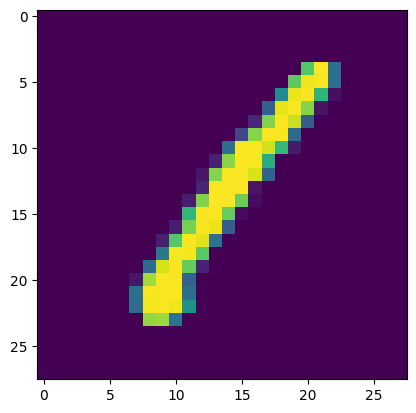

In [8]:
plt.imshow(train_x[0][0])
print(train_y[0])

augmentation block

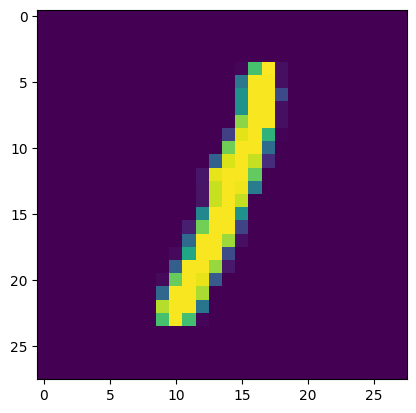

In [9]:
aug_train_df = train_df.sample(frac=0.5)

aug_train_x = torch.FloatTensor(np.reshape(np.array(aug_train_df.drop('label', axis=1)), (-1, 1, 28, 28)))
aug_train_y = torch.LongTensor(np.array(aug_train_df['label']))

Horizontal_Flipping_Transformation = transforms.Compose([
    transforms.RandomRotation(30)
])

aug_train_x_new = aug_train_x.detach().clone()
# Testing The Transformation...
for i in range(aug_train_x.shape[0]):
    aug_train_x_new[i] = Horizontal_Flipping_Transformation(aug_train_x[i])

train_x = torch.cat((train_x, aug_train_x_new))
train_y = torch.cat((train_y, aug_train_y))

plt.imshow(aug_train_x_new[0][0])

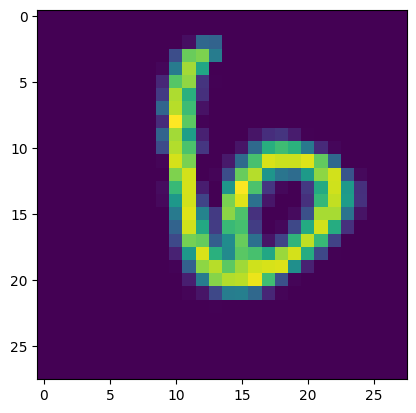

In [10]:
aug_train_df = train_df.sample(frac=0.5)

aug_train_x = torch.FloatTensor(np.reshape(np.array(aug_train_df.drop('label', axis=1)), (-1, 1, 28, 28)))
aug_train_y = torch.LongTensor(np.array(aug_train_df['label']))

Horizontal_Flipping_Transformation = transforms.Compose([
    transforms.ElasticTransform(alpha=100.0)
])

aug_train_x_new = aug_train_x.detach().clone()
# Testing The Transformation...
for i in range(aug_train_x.shape[0]):
    aug_train_x_new[i] = Horizontal_Flipping_Transformation(aug_train_x[i])

train_x = torch.cat((train_x, aug_train_x_new))
train_y = torch.cat((train_y, aug_train_y))

plt.imshow(aug_train_x_new[0][0])

In [11]:
training_data = TensorDataset(train_x, train_y)
test_data = TensorDataset(test_x, test_y)

In [12]:
batch_size = 128

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [13]:
device = ('cuda' if torch.cuda.is_available()
          else 'mps' if torch.backends.mps.is_available()
          else 'cpu')
print(f'device: {device}')

device: cuda


In [14]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.AvgPool2d(2),
        nn.GELU(),
        nn.Conv2d(16, 32, 3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.AvgPool2d(2),
        nn.GELU(),
        nn.Conv2d(32, 64, 3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.AvgPool2d(2),
        nn.GELU(),
        nn.Conv2d(64, 128, 3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.AvgPool2d(2),
        nn.GELU(),
        nn.Conv2d(128, 10, 3, stride=3, padding=1),
    )
  def forward(self, x):
    x = self.main(x)
    return x

In [15]:
model = Net().to(device)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=35, gamma=0.1)

In [17]:
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

In [18]:
num_epochs = 120

print('Start training loop')
start_time = time.time()

best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}\n-------------------------------')
    epoch_start_time = time.time()

    running_loss = 0.0
    running_corrects = 0

    # training phase
    model.train()
    for x, y in tqdm.tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x).view(len(x), -1)
        loss = loss_fn(pred, y)

        running_loss += loss.item() * x.size(0)
        running_corrects += torch.sum(pred.argmax(1)==y.data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_x)
    train_acc = running_corrects.double() / len(train_x)
    if epoch != 0:
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc.detach().cpu())
    print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}\n')

    running_loss = 0.0
    running_corrects = 0

    # testing phase
    with torch.no_grad():
        for x, y in tqdm.tqdm(test_dataloader):
            x, y = x.to(device), y.to(device)
            pred = model(x).view(len(x), -1)
            loss = loss_fn(pred, y)

            running_loss += loss.item() * x.size(0)
            running_corrects += torch.sum(pred.argmax(1)==y.data)

    test_loss = running_loss / len(test_x)
    test_acc = running_corrects.double() / len(test_x)
    if epoch != 0:
        test_loss_hist.append(test_loss)
        test_acc_hist.append(test_acc.detach().cpu())
    print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch time: {(time.time() - epoch_start_time)/60}min\n')

    # if epoch%10 == 0:
    #     plt.plot(train_loss_hist, label='train')
    #     plt.plot(test_loss_hist, label='test')
    #     plt.legend()
    #     plt.show()
    #     plt.plot(train_acc_hist, label='train')
    #     plt.plot(test_acc_hist, label='test')
    #     plt.legend()
    #     plt.show()

    scheduler.step()

end_time = time.time()
print(f'Done\nTraining time {(end_time - start_time)/60}min')

Start training loop
Epoch 1/120
-------------------------------


100%|██████████| 657/657 [00:04<00:00, 144.50it/s]


Train loss: 0.9416, accuracy: 0.7624



100%|██████████| 99/99 [00:00<00:00, 407.38it/s]


Test loss: 0.2107, accuracy: 0.9536
Epoch time: 0.08021856149037679min

Epoch 2/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 270.38it/s]


Train loss: 0.2315, accuracy: 0.9370



100%|██████████| 99/99 [00:00<00:00, 449.56it/s]


Test loss: 0.1214, accuracy: 0.9697
Epoch time: 0.0445542573928833min

Epoch 3/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 271.38it/s]


Train loss: 0.1612, accuracy: 0.9537



100%|██████████| 99/99 [00:00<00:00, 441.62it/s]


Test loss: 0.0912, accuracy: 0.9754
Epoch time: 0.04440911213556926min

Epoch 4/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 247.31it/s]


Train loss: 0.1300, accuracy: 0.9621



100%|██████████| 99/99 [00:00<00:00, 294.18it/s]


Test loss: 0.0759, accuracy: 0.9780
Epoch time: 0.05025009314219157min

Epoch 5/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 240.91it/s]


Train loss: 0.1116, accuracy: 0.9673



100%|██████████| 99/99 [00:00<00:00, 438.99it/s]


Test loss: 0.0653, accuracy: 0.9808
Epoch time: 0.04950887362162272min

Epoch 6/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 271.74it/s]


Train loss: 0.0991, accuracy: 0.9708



100%|██████████| 99/99 [00:00<00:00, 433.79it/s]


Test loss: 0.0571, accuracy: 0.9833
Epoch time: 0.04440393845240275min

Epoch 7/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 274.19it/s]


Train loss: 0.0898, accuracy: 0.9736



100%|██████████| 99/99 [00:00<00:00, 446.30it/s]


Test loss: 0.0506, accuracy: 0.9842
Epoch time: 0.04395369291305542min

Epoch 8/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 273.60it/s]


Train loss: 0.0825, accuracy: 0.9756



100%|██████████| 99/99 [00:00<00:00, 443.82it/s]


Test loss: 0.0455, accuracy: 0.9858
Epoch time: 0.04404051303863525min

Epoch 9/120
-------------------------------


100%|██████████| 657/657 [00:03<00:00, 211.50it/s]


Train loss: 0.0766, accuracy: 0.9770



100%|██████████| 99/99 [00:00<00:00, 440.35it/s]


Test loss: 0.0413, accuracy: 0.9875
Epoch time: 0.05582575798034668min

Epoch 10/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 269.78it/s]


Train loss: 0.0715, accuracy: 0.9785



100%|██████████| 99/99 [00:00<00:00, 424.27it/s]


Test loss: 0.0378, accuracy: 0.9887
Epoch time: 0.04481088717778524min

Epoch 11/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 273.77it/s]


Train loss: 0.0672, accuracy: 0.9798



100%|██████████| 99/99 [00:00<00:00, 434.32it/s]


Test loss: 0.0348, accuracy: 0.9896
Epoch time: 0.04412897030512492min

Epoch 12/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 273.05it/s]


Train loss: 0.0633, accuracy: 0.9810



100%|██████████| 99/99 [00:00<00:00, 445.17it/s]


Test loss: 0.0323, accuracy: 0.9903
Epoch time: 0.044153388341267905min

Epoch 13/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 237.12it/s]


Train loss: 0.0599, accuracy: 0.9820



100%|██████████| 99/99 [00:00<00:00, 291.20it/s]


Test loss: 0.0302, accuracy: 0.9908
Epoch time: 0.052177810668945314min

Epoch 14/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 241.14it/s]


Train loss: 0.0568, accuracy: 0.9829



100%|██████████| 99/99 [00:00<00:00, 418.68it/s]


Test loss: 0.0283, accuracy: 0.9913
Epoch time: 0.049713162581125896min

Epoch 15/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 270.04it/s]


Train loss: 0.0540, accuracy: 0.9838



100%|██████████| 99/99 [00:00<00:00, 403.15it/s]


Test loss: 0.0267, accuracy: 0.9915
Epoch time: 0.04499737819035848min

Epoch 16/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 271.98it/s]


Train loss: 0.0514, accuracy: 0.9845



100%|██████████| 99/99 [00:00<00:00, 443.48it/s]


Test loss: 0.0253, accuracy: 0.9920
Epoch time: 0.044303739070892335min

Epoch 17/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 268.62it/s]


Train loss: 0.0490, accuracy: 0.9854



100%|██████████| 99/99 [00:00<00:00, 454.78it/s]


Test loss: 0.0241, accuracy: 0.9921
Epoch time: 0.04475922187169393min

Epoch 18/120
-------------------------------


100%|██████████| 657/657 [00:03<00:00, 212.08it/s]


Train loss: 0.0468, accuracy: 0.9859



100%|██████████| 99/99 [00:00<00:00, 441.40it/s]


Test loss: 0.0230, accuracy: 0.9925
Epoch time: 0.055715171496073405min

Epoch 19/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 271.74it/s]


Train loss: 0.0447, accuracy: 0.9866



100%|██████████| 99/99 [00:00<00:00, 438.13it/s]


Test loss: 0.0219, accuracy: 0.9933
Epoch time: 0.044393237431844076min

Epoch 20/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 270.44it/s]


Train loss: 0.0428, accuracy: 0.9872



100%|██████████| 99/99 [00:00<00:00, 442.66it/s]


Test loss: 0.0210, accuracy: 0.9937
Epoch time: 0.04453337589899699min

Epoch 21/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 265.92it/s]


Train loss: 0.0410, accuracy: 0.9878



100%|██████████| 99/99 [00:00<00:00, 444.87it/s]


Test loss: 0.0201, accuracy: 0.9938
Epoch time: 0.045228445529937746min

Epoch 22/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 232.46it/s]


Train loss: 0.0393, accuracy: 0.9883



100%|██████████| 99/99 [00:00<00:00, 308.10it/s]


Test loss: 0.0193, accuracy: 0.9940
Epoch time: 0.052791929244995116min

Epoch 23/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 248.29it/s]


Train loss: 0.0377, accuracy: 0.9888



100%|██████████| 99/99 [00:00<00:00, 422.05it/s]


Test loss: 0.0186, accuracy: 0.9944
Epoch time: 0.04833200772603353min

Epoch 24/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 266.84it/s]


Train loss: 0.0362, accuracy: 0.9895



100%|██████████| 99/99 [00:00<00:00, 440.45it/s]


Test loss: 0.0179, accuracy: 0.9944
Epoch time: 0.045212507247924805min

Epoch 25/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 269.69it/s]


Train loss: 0.0347, accuracy: 0.9901



100%|██████████| 99/99 [00:00<00:00, 437.06it/s]


Test loss: 0.0173, accuracy: 0.9947
Epoch time: 0.044712193806966144min

Epoch 26/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 269.07it/s]


Train loss: 0.0333, accuracy: 0.9906



100%|██████████| 99/99 [00:00<00:00, 307.79it/s]


Test loss: 0.0167, accuracy: 0.9948
Epoch time: 0.04646600484848022min

Epoch 27/120
-------------------------------


100%|██████████| 657/657 [00:03<00:00, 217.74it/s]


Train loss: 0.0320, accuracy: 0.9913



100%|██████████| 99/99 [00:00<00:00, 440.68it/s]


Test loss: 0.0161, accuracy: 0.9948
Epoch time: 0.05438029766082764min

Epoch 28/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 269.47it/s]


Train loss: 0.0308, accuracy: 0.9918



100%|██████████| 99/99 [00:00<00:00, 414.30it/s]


Test loss: 0.0155, accuracy: 0.9949
Epoch time: 0.04498450358708699min

Epoch 29/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 270.51it/s]


Train loss: 0.0296, accuracy: 0.9922



100%|██████████| 99/99 [00:00<00:00, 439.47it/s]


Test loss: 0.0150, accuracy: 0.9951
Epoch time: 0.0445466677347819min

Epoch 30/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 269.15it/s]


Train loss: 0.0284, accuracy: 0.9926



100%|██████████| 99/99 [00:00<00:00, 447.78it/s]


Test loss: 0.0145, accuracy: 0.9951
Epoch time: 0.04460136493047078min

Epoch 31/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 224.80it/s]


Train loss: 0.0273, accuracy: 0.9930



100%|██████████| 99/99 [00:00<00:00, 306.02it/s]


Test loss: 0.0140, accuracy: 0.9952
Epoch time: 0.05441168149312337min

Epoch 32/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 258.66it/s]


Train loss: 0.0262, accuracy: 0.9934



100%|██████████| 99/99 [00:00<00:00, 444.43it/s]


Test loss: 0.0136, accuracy: 0.9952
Epoch time: 0.04631385008494059min

Epoch 33/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 270.52it/s]


Train loss: 0.0252, accuracy: 0.9938



100%|██████████| 99/99 [00:00<00:00, 444.57it/s]


Test loss: 0.0132, accuracy: 0.9954
Epoch time: 0.0445371150970459min

Epoch 34/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 268.44it/s]


Train loss: 0.0242, accuracy: 0.9942



100%|██████████| 99/99 [00:00<00:00, 415.74it/s]


Test loss: 0.0128, accuracy: 0.9956
Epoch time: 0.04513174295425415min

Epoch 35/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 259.48it/s]


Train loss: 0.0233, accuracy: 0.9945



100%|██████████| 99/99 [00:00<00:00, 293.54it/s]


Test loss: 0.0124, accuracy: 0.9957
Epoch time: 0.04821226994196574min

Epoch 36/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 220.22it/s]


Train loss: 0.0224, accuracy: 0.9948



100%|██████████| 99/99 [00:00<00:00, 438.15it/s]


Test loss: 0.0120, accuracy: 0.9960
Epoch time: 0.053892985979715986min

Epoch 37/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 269.96it/s]


Train loss: 0.0215, accuracy: 0.9951



100%|██████████| 99/99 [00:00<00:00, 436.54it/s]


Test loss: 0.0117, accuracy: 0.9961
Epoch time: 0.044707266489664714min

Epoch 38/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 269.32it/s]


Train loss: 0.0207, accuracy: 0.9954



100%|██████████| 99/99 [00:00<00:00, 440.92it/s]


Test loss: 0.0113, accuracy: 0.9960
Epoch time: 0.04463831981023152min

Epoch 39/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 268.51it/s]


Train loss: 0.0199, accuracy: 0.9958



100%|██████████| 99/99 [00:00<00:00, 425.20it/s]


Test loss: 0.0110, accuracy: 0.9963
Epoch time: 0.04497534434000651min

Epoch 40/120
-------------------------------


100%|██████████| 657/657 [00:03<00:00, 216.14it/s]


Train loss: 0.0191, accuracy: 0.9960



100%|██████████| 99/99 [00:00<00:00, 305.15it/s]


Test loss: 0.0107, accuracy: 0.9965
Epoch time: 0.05637922684351603min

Epoch 41/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 268.28it/s]


Train loss: 0.0179, accuracy: 0.9955



100%|██████████| 99/99 [00:00<00:00, 443.49it/s]


Test loss: 0.0093, accuracy: 0.9971
Epoch time: 0.04489897886912028min

Epoch 42/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 266.03it/s]


Train loss: 0.0169, accuracy: 0.9961



100%|██████████| 99/99 [00:00<00:00, 424.20it/s]


Test loss: 0.0091, accuracy: 0.9971
Epoch time: 0.045392191410064696min

Epoch 43/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 265.31it/s]


Train loss: 0.0166, accuracy: 0.9962



100%|██████████| 99/99 [00:00<00:00, 433.75it/s]


Test loss: 0.0090, accuracy: 0.9971
Epoch time: 0.04545150995254517min

Epoch 44/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 243.47it/s]


Train loss: 0.0164, accuracy: 0.9963



100%|██████████| 99/99 [00:00<00:00, 258.88it/s]


Test loss: 0.0089, accuracy: 0.9971
Epoch time: 0.05170392990112305min

Epoch 45/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 232.09it/s]


Train loss: 0.0163, accuracy: 0.9963



100%|██████████| 99/99 [00:00<00:00, 427.71it/s]


Test loss: 0.0088, accuracy: 0.9973
Epoch time: 0.051471551259358726min

Epoch 46/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 266.63it/s]


Train loss: 0.0161, accuracy: 0.9965



100%|██████████| 99/99 [00:00<00:00, 431.72it/s]


Test loss: 0.0087, accuracy: 0.9973
Epoch time: 0.04512784481048584min

Epoch 47/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 268.10it/s]


Train loss: 0.0160, accuracy: 0.9965



100%|██████████| 99/99 [00:00<00:00, 432.56it/s]


Test loss: 0.0086, accuracy: 0.9973
Epoch time: 0.04504773219426473min

Epoch 48/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 268.72it/s]


Train loss: 0.0159, accuracy: 0.9967



100%|██████████| 99/99 [00:00<00:00, 430.41it/s]


Test loss: 0.0085, accuracy: 0.9974
Epoch time: 0.0449220061302185min

Epoch 49/120
-------------------------------


100%|██████████| 657/657 [00:03<00:00, 210.52it/s]


Train loss: 0.0157, accuracy: 0.9968



100%|██████████| 99/99 [00:00<00:00, 438.77it/s]


Test loss: 0.0084, accuracy: 0.9974
Epoch time: 0.05606421629587809min

Epoch 50/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 265.87it/s]


Train loss: 0.0156, accuracy: 0.9968



100%|██████████| 99/99 [00:00<00:00, 426.17it/s]


Test loss: 0.0084, accuracy: 0.9977
Epoch time: 0.04550702969233195min

Epoch 51/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 266.57it/s]


Train loss: 0.0155, accuracy: 0.9968



100%|██████████| 99/99 [00:00<00:00, 418.37it/s]


Test loss: 0.0083, accuracy: 0.9977
Epoch time: 0.045299065113067624min

Epoch 52/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 267.86it/s]


Train loss: 0.0154, accuracy: 0.9969



100%|██████████| 99/99 [00:00<00:00, 430.15it/s]


Test loss: 0.0083, accuracy: 0.9977
Epoch time: 0.04495796362559001min

Epoch 53/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 232.92it/s]


Train loss: 0.0153, accuracy: 0.9970



100%|██████████| 99/99 [00:00<00:00, 299.26it/s]


Test loss: 0.0082, accuracy: 0.9978
Epoch time: 0.05286237398783366min

Epoch 54/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 246.52it/s]


Train loss: 0.0152, accuracy: 0.9970



100%|██████████| 99/99 [00:00<00:00, 434.55it/s]


Test loss: 0.0082, accuracy: 0.9978
Epoch time: 0.048464524745941165min

Epoch 55/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 268.12it/s]


Train loss: 0.0151, accuracy: 0.9970



100%|██████████| 99/99 [00:00<00:00, 434.37it/s]


Test loss: 0.0081, accuracy: 0.9979
Epoch time: 0.04509963194529216min

Epoch 56/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 262.92it/s]


Train loss: 0.0150, accuracy: 0.9971



100%|██████████| 99/99 [00:00<00:00, 418.46it/s]


Test loss: 0.0081, accuracy: 0.9979
Epoch time: 0.045851246515909834min

Epoch 57/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 267.10it/s]


Train loss: 0.0149, accuracy: 0.9971



100%|██████████| 99/99 [00:00<00:00, 316.10it/s]


Test loss: 0.0080, accuracy: 0.9979
Epoch time: 0.046523205439249676min

Epoch 58/120
-------------------------------


100%|██████████| 657/657 [00:03<00:00, 216.40it/s]


Train loss: 0.0148, accuracy: 0.9971



100%|██████████| 99/99 [00:00<00:00, 409.39it/s]


Test loss: 0.0080, accuracy: 0.9979
Epoch time: 0.05484876235326131min

Epoch 59/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 269.15it/s]


Train loss: 0.0147, accuracy: 0.9972



100%|██████████| 99/99 [00:00<00:00, 423.01it/s]


Test loss: 0.0079, accuracy: 0.9979
Epoch time: 0.04495171308517456min

Epoch 60/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 270.30it/s]


Train loss: 0.0147, accuracy: 0.9972



100%|██████████| 99/99 [00:00<00:00, 433.34it/s]


Test loss: 0.0079, accuracy: 0.9979
Epoch time: 0.04463879267374674min

Epoch 61/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 269.23it/s]


Train loss: 0.0146, accuracy: 0.9973



100%|██████████| 99/99 [00:00<00:00, 427.39it/s]


Test loss: 0.0078, accuracy: 0.9979
Epoch time: 0.044872820377349854min

Epoch 62/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 224.30it/s]


Train loss: 0.0145, accuracy: 0.9973



100%|██████████| 99/99 [00:00<00:00, 293.90it/s]


Test loss: 0.0078, accuracy: 0.9979
Epoch time: 0.05475610891977946min

Epoch 63/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 255.72it/s]


Train loss: 0.0144, accuracy: 0.9973



100%|██████████| 99/99 [00:00<00:00, 432.43it/s]


Test loss: 0.0078, accuracy: 0.9979
Epoch time: 0.04691579739252726min

Epoch 64/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 268.38it/s]


Train loss: 0.0143, accuracy: 0.9974



100%|██████████| 99/99 [00:00<00:00, 427.89it/s]


Test loss: 0.0077, accuracy: 0.9979
Epoch time: 0.044960884253184min

Epoch 65/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 266.79it/s]


Train loss: 0.0143, accuracy: 0.9974



100%|██████████| 99/99 [00:00<00:00, 415.67it/s]


Test loss: 0.0077, accuracy: 0.9979
Epoch time: 0.045363986492156984min

Epoch 66/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 255.47it/s]


Train loss: 0.0142, accuracy: 0.9974



100%|██████████| 99/99 [00:00<00:00, 286.39it/s]


Test loss: 0.0076, accuracy: 0.9979
Epoch time: 0.048929413159688316min

Epoch 67/120
-------------------------------


100%|██████████| 657/657 [00:03<00:00, 218.81it/s]


Train loss: 0.0141, accuracy: 0.9974



100%|██████████| 99/99 [00:00<00:00, 424.04it/s]


Test loss: 0.0076, accuracy: 0.9979
Epoch time: 0.05423843463261922min

Epoch 68/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 267.06it/s]


Train loss: 0.0140, accuracy: 0.9975



100%|██████████| 99/99 [00:00<00:00, 435.93it/s]


Test loss: 0.0076, accuracy: 0.9979
Epoch time: 0.045060372352600096min

Epoch 69/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 266.10it/s]


Train loss: 0.0139, accuracy: 0.9975



100%|██████████| 99/99 [00:00<00:00, 432.82it/s]


Test loss: 0.0075, accuracy: 0.9979
Epoch time: 0.04531704584757487min

Epoch 70/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 267.64it/s]


Train loss: 0.0139, accuracy: 0.9976



100%|██████████| 99/99 [00:00<00:00, 401.94it/s]


Test loss: 0.0075, accuracy: 0.9979
Epoch time: 0.04547356764475505min

Epoch 71/120
-------------------------------


100%|██████████| 657/657 [00:03<00:00, 214.67it/s]


Train loss: 0.0138, accuracy: 0.9976



100%|██████████| 99/99 [00:00<00:00, 284.99it/s]


Test loss: 0.0075, accuracy: 0.9979
Epoch time: 0.05707517067591349min

Epoch 72/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 262.28it/s]


Train loss: 0.0137, accuracy: 0.9976



100%|██████████| 99/99 [00:00<00:00, 415.26it/s]


Test loss: 0.0074, accuracy: 0.9979
Epoch time: 0.045975641409556074min

Epoch 73/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 266.96it/s]


Train loss: 0.0137, accuracy: 0.9976



100%|██████████| 99/99 [00:00<00:00, 428.83it/s]


Test loss: 0.0074, accuracy: 0.9979
Epoch time: 0.04511157274246216min

Epoch 74/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 265.34it/s]


Train loss: 0.0136, accuracy: 0.9977



100%|██████████| 99/99 [00:00<00:00, 427.48it/s]


Test loss: 0.0073, accuracy: 0.9979
Epoch time: 0.04551451206207276min

Epoch 75/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 242.66it/s]


Train loss: 0.0135, accuracy: 0.9977



100%|██████████| 99/99 [00:00<00:00, 297.72it/s]


Test loss: 0.0073, accuracy: 0.9979
Epoch time: 0.050952502091725665min

Epoch 76/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 231.21it/s]


Train loss: 0.0134, accuracy: 0.9977



100%|██████████| 99/99 [00:00<00:00, 435.53it/s]


Test loss: 0.0073, accuracy: 0.9979
Epoch time: 0.051407941182454425min

Epoch 77/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 262.31it/s]


Train loss: 0.0134, accuracy: 0.9977



100%|██████████| 99/99 [00:00<00:00, 416.92it/s]


Test loss: 0.0073, accuracy: 0.9979
Epoch time: 0.046029786268870033min

Epoch 78/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 265.50it/s]


Train loss: 0.0133, accuracy: 0.9977



100%|██████████| 99/99 [00:00<00:00, 441.92it/s]


Test loss: 0.0072, accuracy: 0.9980
Epoch time: 0.04540241559346517min

Epoch 79/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 264.53it/s]


Train loss: 0.0132, accuracy: 0.9978



100%|██████████| 99/99 [00:00<00:00, 428.36it/s]


Test loss: 0.0072, accuracy: 0.9981
Epoch time: 0.04555503924687703min

Epoch 80/120
-------------------------------


100%|██████████| 657/657 [00:03<00:00, 208.84it/s]


Train loss: 0.0132, accuracy: 0.9978



100%|██████████| 99/99 [00:00<00:00, 437.51it/s]


Test loss: 0.0072, accuracy: 0.9982
Epoch time: 0.05662602186203003min

Epoch 81/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 263.06it/s]


Train loss: 0.0133, accuracy: 0.9978



100%|██████████| 99/99 [00:00<00:00, 419.26it/s]


Test loss: 0.0070, accuracy: 0.9982
Epoch time: 0.04583282073338826min

Epoch 82/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 266.12it/s]


Train loss: 0.0131, accuracy: 0.9979



100%|██████████| 99/99 [00:00<00:00, 422.21it/s]


Test loss: 0.0070, accuracy: 0.9983
Epoch time: 0.04542304277420044min

Epoch 83/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 262.51it/s]


Train loss: 0.0130, accuracy: 0.9979



100%|██████████| 99/99 [00:00<00:00, 436.17it/s]


Test loss: 0.0070, accuracy: 0.9983
Epoch time: 0.04579402605692546min

Epoch 84/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 221.24it/s]


Train loss: 0.0130, accuracy: 0.9979



100%|██████████| 99/99 [00:00<00:00, 269.49it/s]


Test loss: 0.0069, accuracy: 0.9983
Epoch time: 0.05606759389241536min

Epoch 85/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 252.65it/s]


Train loss: 0.0130, accuracy: 0.9979



100%|██████████| 99/99 [00:00<00:00, 424.55it/s]


Test loss: 0.0069, accuracy: 0.9983
Epoch time: 0.0474867582321167min

Epoch 86/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 264.46it/s]


Train loss: 0.0130, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 432.33it/s]


Test loss: 0.0069, accuracy: 0.9983
Epoch time: 0.045591576894124346min

Epoch 87/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 265.18it/s]


Train loss: 0.0130, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 412.91it/s]


Test loss: 0.0069, accuracy: 0.9983
Epoch time: 0.04565196434656779min

Epoch 88/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 253.24it/s]


Train loss: 0.0129, accuracy: 0.9979



100%|██████████| 99/99 [00:00<00:00, 272.10it/s]


Test loss: 0.0069, accuracy: 0.9983
Epoch time: 0.04969164530436198min

Epoch 89/120
-------------------------------


100%|██████████| 657/657 [00:03<00:00, 218.73it/s]


Train loss: 0.0129, accuracy: 0.9979



100%|██████████| 99/99 [00:00<00:00, 429.27it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.05412561098734538min

Epoch 90/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 265.57it/s]


Train loss: 0.0129, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 427.06it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.04546568791071574min

Epoch 91/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 266.90it/s]


Train loss: 0.0129, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 413.43it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.0454324205716451min

Epoch 92/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 264.54it/s]


Train loss: 0.0129, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 422.81it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.04558975299199422min

Epoch 93/120
-------------------------------


100%|██████████| 657/657 [00:03<00:00, 209.39it/s]


Train loss: 0.0129, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 381.65it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.05697441101074219min

Epoch 94/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 265.29it/s]


Train loss: 0.0129, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 438.67it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.0453454852104187min

Epoch 95/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 265.86it/s]


Train loss: 0.0129, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 417.34it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.04546000957489014min

Epoch 96/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 264.62it/s]


Train loss: 0.0129, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 429.61it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.04559740622838338min

Epoch 97/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 237.93it/s]


Train loss: 0.0129, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 289.28it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.05202442407608032min

Epoch 98/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 230.89it/s]


Train loss: 0.0128, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 430.36it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.05153729518254598min

Epoch 99/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 265.23it/s]


Train loss: 0.0128, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 426.64it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.04559810558954875min

Epoch 100/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 268.21it/s]


Train loss: 0.0128, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 415.07it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.045107555389404294min

Epoch 101/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 266.05it/s]


Train loss: 0.0128, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 439.04it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.04520951906840007min

Epoch 102/120
-------------------------------


100%|██████████| 657/657 [00:03<00:00, 209.31it/s]


Train loss: 0.0128, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 431.52it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.056490699450174965min

Epoch 103/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 267.65it/s]


Train loss: 0.0128, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 440.18it/s]


Test loss: 0.0068, accuracy: 0.9983
Epoch time: 0.04503550132115682min

Epoch 104/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 264.87it/s]


Train loss: 0.0128, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 406.03it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.045721912384033205min

Epoch 105/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 263.35it/s]


Train loss: 0.0128, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 439.35it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.04562696218490601min

Epoch 106/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 227.34it/s]


Train loss: 0.0128, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 289.19it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.054256538550059min

Epoch 107/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 247.75it/s]


Train loss: 0.0128, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 420.49it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.04840232133865356min

Epoch 108/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 262.58it/s]


Train loss: 0.0128, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 422.85it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.045950818061828616min

Epoch 109/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 263.29it/s]


Train loss: 0.0128, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 428.96it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.04571563005447388min

Epoch 110/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 259.44it/s]


Train loss: 0.0127, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 274.11it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.048572659492492676min

Epoch 111/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 219.50it/s]


Train loss: 0.0127, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 409.68it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.0541352907816569min

Epoch 112/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 264.84it/s]


Train loss: 0.0127, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 417.96it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.045761048793792725min

Epoch 113/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 263.23it/s]


Train loss: 0.0127, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 410.35it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.04587953885396322min

Epoch 114/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 265.55it/s]


Train loss: 0.0127, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 426.98it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.04548980792363485min

Epoch 115/120
-------------------------------


100%|██████████| 657/657 [00:03<00:00, 216.87it/s]


Train loss: 0.0127, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 287.93it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.0564758022626241min

Epoch 116/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 264.88it/s]


Train loss: 0.0127, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 406.35it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.04562463760375977min

Epoch 117/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 262.41it/s]


Train loss: 0.0127, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 413.29it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.04604764779408773min

Epoch 118/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 261.61it/s]


Train loss: 0.0127, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 403.58it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.04626514514287313min

Epoch 119/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 235.89it/s]


Train loss: 0.0127, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 274.96it/s]


Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.05279070933659871min

Epoch 120/120
-------------------------------


100%|██████████| 657/657 [00:02<00:00, 230.58it/s]


Train loss: 0.0127, accuracy: 0.9980



100%|██████████| 99/99 [00:00<00:00, 437.52it/s]

Test loss: 0.0067, accuracy: 0.9983
Epoch time: 0.05163253943125407min

Done
Training time 5.771501131852468min


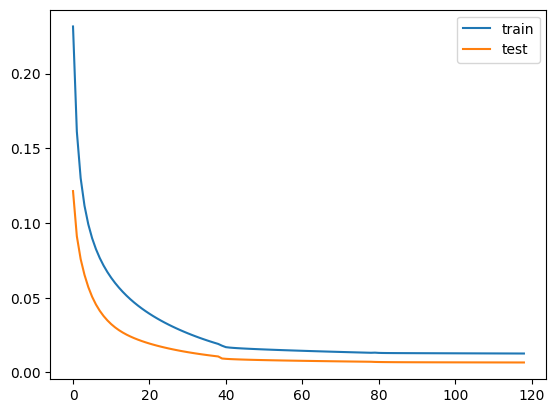

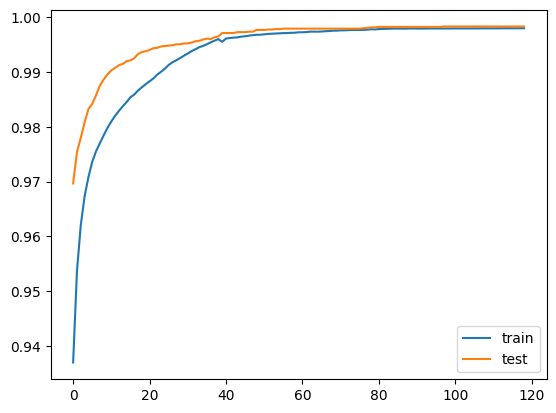

In [19]:
plt.plot(train_loss_hist, label='train')
plt.plot(test_loss_hist, label='test')
plt.legend()
plt.show()
plt.plot(train_acc_hist, label='train')
plt.plot(test_acc_hist, label='test')
plt.legend()
plt.show()

In [20]:
def make_submission(x, model, y_label, sample, submission_path):
    prediction = np.argmax(model(x).view(len(x), -1).cpu().detach().numpy(), axis=1)
    submission = sample.copy()
    submission[y_label] = prediction
    submission.to_csv(submission_path, index=False)

In [21]:
valid_df = pd.read_csv(dataroot + 'test.csv')

valid_x = torch.FloatTensor(np.reshape(np.array(valid_df), (-1, 1, 28, 28))).to(device)

In [22]:
y_label = 'Label'
sample = pd.read_csv(dataroot + 'sample_submission.csv')

submission_path = dataroot + 'submission.csv'

make_submission(valid_x, model, y_label, sample, submission_path)